In [2]:
from fastai.vision import *

In [3]:
DATA_PATH = Path.home() / "data/people"
CLASSES = ["man", "woman", "drag"]

In [9]:
class Category:

    def __init__(self, name, max_pics=300):
        self.name = name
        self.path = DATA_PATH / name
        self.urls_file = DATA_PATH / f"{name}.txt"
        self.max_pics = max_pics
        self.path.mkdir(parents=True, exist_ok=True)
    
    def get_images(self):
        """Download the images for this category"""
        download_images(self.urls_file, self.path, max_pics=self.max_pics)
        verify_images(self.path, delete=True, max_size=500)
        

In [11]:
# Download the images
for cls in CLASSES:
    cat = Category(cls)
    cat.get_images()

In [4]:
np.random.seed(42)
data = ImageDataBunch.from_folder(DATA_PATH, train=".", valid_pct=0.2,
        ds_tfms=get_transforms(), size=224, num_workers=4).normalize(imagenet_stats)

In [5]:
data.classes, data.c, len(data.train_ds), len(data.valid_ds)

(['drag', 'man', 'woman'], 3, 720, 180)

## Train model

In [15]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate)

In [16]:
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,error_rate,time
0,1.338299,0.560013,0.177778,00:10
1,0.875357,0.463866,0.144444,00:07
2,0.689930,0.373009,0.127778,00:06
3,0.554220,0.365639,0.138889,00:06


In [17]:
learn.save('stage-1')

In [18]:
learn.unfreeze()

In [19]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


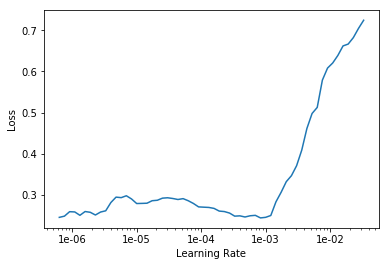

In [20]:
# If the plot is not showing try to give a start and end learning rate
# learn.lr_find(start_lr=1e-5, end_lr=1e-1)
learn.recorder.plot()

In [21]:
learn.fit_one_cycle(2, max_lr=slice(3e-6,3e-4))

epoch,train_loss,valid_loss,error_rate,time
0,0.242985,0.339362,0.127778,00:09
1,0.223227,0.310673,0.122222,00:09


In [22]:
learn.save('stage-2')

## Interpretation

In [23]:
learn.load('stage-2');

In [24]:
interp = ClassificationInterpretation.from_learner(learn)

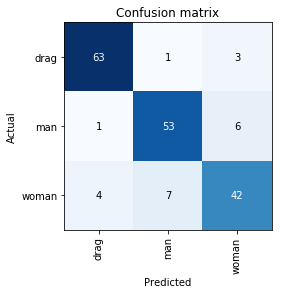

In [25]:
interp.plot_confusion_matrix()

## Cleaning up the Dataset

In [6]:
from fastai.widgets import *

In [7]:
db = (ImageList.from_folder(DATA_PATH)
                   .split_none()
                   .label_from_folder()
                   .transform(get_transforms(), size=224)
                   .databunch()
     )

In [8]:
learn_cln = cnn_learner(db, models.resnet34, metrics=error_rate)

learn_cln.load('stage-2');

In [9]:
ds, idxs = DatasetFormatter().from_toplosses(learn_cln)

In [11]:
# Don't run this in google colab or any other instances running jupyter lab.
# If you do run this on Jupyter Lab, you need to restart your runtime and
# runtime state including all local variables will be lost.
ImageCleaner(ds, idxs, DATA_PATH)

Button(button_style='primary', description='Next Batch', layout=Layout(width='auto'), style=ButtonStyle())

In [15]:
cleaned_data = ImageDataBunch.from_csv(DATA_PATH, folder=".", valid_pct=0.2, csv_labels='cleaned.csv',
        ds_tfms=get_transforms(), size=224, num_workers=4).normalize(imagenet_stats)

In [16]:
learn = cnn_learner(cleaned_data, models.resnet34, metrics=error_rate)

In [17]:
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,error_rate,time
0,1.311359,0.523924,0.152542,00:08
1,0.846003,0.369824,0.096045,00:07
2,0.607843,0.308457,0.101695,00:06
3,0.499478,0.303295,0.084746,00:07


In [18]:
learn.save('stage-1')

In [19]:
learn.unfreeze()

In [20]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


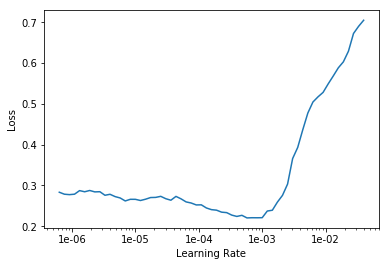

In [21]:
learn.recorder.plot()

In [23]:
learn.load('stage-1')
learn.unfreeze()
learn.fit_one_cycle(2, max_lr=slice(3e-6,3e-3))

epoch,train_loss,valid_loss,error_rate,time
0,0.334862,0.372590,0.118644,00:09
1,0.291950,0.302156,0.067797,00:09


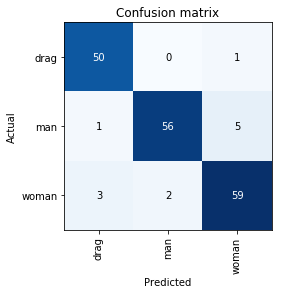

In [24]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()